In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# **Projective Distortion Removal**

In [22]:
def get_4_points(im1,n):
  # function to get 4 points corresponding to 2 pairs of parallel lines in the image
  if n==1:
    # use Q for easy understanding.
    P1=[583,646]   #x1,y1
    P2=[779,671]  #x2,y2
    P3=[771,266] #x3,y3
    P4=[594,210]  #x4,y4

    Q1=P1
    Q2=P4
    Q3=P2
    Q4=P3
    
  elif n==2:
    P1=[618,510]
    P2=[369,548]
    P3=[361,853]
    P4=[644,973]

    Q1=P1
    Q2=P4
    Q3=P3
    Q4=P2
  elif n ==3:
    P1=[2092,1481]   #x1,y1
    P2=[2693,1322] #x2,y2
    P3=[2667,717] #x3,y3
    P4=[2057,700]  #x4,y4

    Q1=P1
    Q2=P4
    Q3=P3
    Q4=P2

  im_copy=im1.copy()
  ##https://www.geeksforgeeks.org/python-opencv-cv2-line-method/ for drawing lines on image
  line_img=cv2.line(im_copy, tuple(P1), tuple(P2), (255,0,0), 5)
  line_img=cv2.line(line_img, tuple(P3), tuple(P4), (255,0,0), 5)
  line_img=cv2.line(line_img, tuple(Q1), tuple(Q2), (0,255,0), 5)
  line_img=cv2.line(line_img, tuple(Q3), tuple(Q4), (0,255,0), 5)
  plt.imshow(line_img)
  plt.title("Parallel Lines")

  return P1,P2,P3,P4,Q1,Q2,Q3,Q4


In [3]:
def get_VanishingPoint(P1,P2,P3,P4):
  # function to compute the homogeneous coordinates of the Vanishing Point
  P_1=np.array(P1)
  P_1=np.append(P_1,1)
  P_2=np.array(P2)
  P_2=np.append(P_2,1)
  l1=np.cross(P_1,P_2)

  P_3=np.array(P3)
  P_3=np.append(P_3,1)
  P_4=np.array(P4)
  P_4=np.append(P_4,1)
  l2=np.cross(P_3,P_4)

  PV1=np.cross(l1,l2)
  PV1=PV1/PV1[2]
  print("Vanishing Point: ",PV1)
  return PV1

In [4]:
def VanishingLine_and_H(PV1,PV2):
  # function to compute the Vanishing Line
  lV=np.cross(PV1,PV2)
  lV=lV/lV[2]
  print("Vanishing Line: ",lV)

  #get the H matrix
  H2=np.array([[1,0,0],[0,1,0],lV])
  print("H: ",H2)
  H2_inv=np.linalg.inv(H2)

  return lV,H2,H2_inv

In [5]:
def get_new_coords(img,H):
  # this function returns the size of the image in the world coordinates after transformation

  width=img.shape[1]
  height=img.shape[0]
  print("width(x)=",width)
  print("height(y)=",height)

  img_coords=np.array([[0,0,1],[0,height,1],[width,0,1],[width,height,1]])  # 4 corners of the image in homogenous coordinates
  print("image coordinates: ",img_coords.T)

  new_coords=np.matmul(H,img_coords.T)  
  new_coords=new_coords/new_coords[2]
  new_coords=np.rint(new_coords).astype(int)
  new_img_coords=new_coords.T[:,:2]
  print("new image coordinates: ",new_img_coords)
  return new_img_coords

def get_mapped_image(im1, new_img_coords,H_inv):
  '''
  We can see from the projected corner points that the origin in this new coordinate is not at (0,0). Hence we need 
  to find the appropriate translation to bring the coordinates along origin.  
  
  Also we need to scale the image so that the final image size is not very large.
  '''
  height,width,_ = im1.shape
  scale1=width/(max(new_img_coords[:,0])-min(new_img_coords[:,0]))  # get a sale along the width (actual width/project_width)
  scale2=height/(max(new_img_coords[:,1])-min(new_img_coords[:,1])) # get a sale along the height (actual height/project_height)
  scale=max(scale1, scale2)   # select the max value as the scale for both width and height (or can use different scales)
  print("scale: ",scale)

  #find the translation to bring the coordinates to positive values
  tx=np.round(np.min(new_img_coords[:,0]))
  ty=np.round(np.min(new_img_coords[:,1]))
  print("tx,ty",tx,ty)

  '''
  Find out the shape of the new image in world coordinates.
  '''

  new_height=np.round((max(new_img_coords[:,1])-min(new_img_coords[:,1]))*scale2).astype(int)
  new_width=np.round((max(new_img_coords[:,0])-min(new_img_coords[:,0]))*scale1).astype(int)
  
  new_image=np.zeros((new_height,new_width,3))

  max_X=im1.shape[1]    # this value will be used to check if the mapped pixels are within the range of the original image so that pixel values are present for them 
  max_Y=im1.shape[0]

  '''
  To find the mapping of every point in the new image to the distorted image, we multiply every point with the inverse
  of the Homography - i.e. map every point in real world coordinates to the image plane and find the correspondence.
  '''
  
  for i in range(0,new_width):  #x
    for j in range(0,new_height): #y

      k1=i/scale1+tx
      k2=j/scale2+ty
      init=np.array((k1,k2,1))
      mapped=np.matmul(H_inv,init)
      mapped=np.rint(mapped/mapped[2])
      mapped=mapped.astype(int)
      if mapped[0]>=0 and mapped[0]<max_X and mapped[1]>=0 and mapped[1]<max_Y:
        new_image[j,i]=im1[mapped[1],mapped[0]]
  
  return new_image.astype(int)

# **Affine Distortion Removal**

In [28]:
def plot_perp_lines(im1,P1,P2,P3,P4):
  img_copy = im1.copy()
  line_img=cv2.line(img_copy, tuple(P1), tuple(P2), (255,0,0), 5)
  line_img=cv2.line(line_img, tuple(P2), tuple(P3), (255,0,0), 5)
  line_img=cv2.line(line_img, tuple(P3), tuple(P4), (0,255,0), 5)
  line_img=cv2.line(line_img, tuple(P4), tuple(P1), (0,255,0), 5)
  plt.figure()
  plt.imshow(line_img)
  plt.title("perpendicular lines")

In [7]:
def get_projected_points(H2,P1,P2,P3,P4):
  # function to project the points onto the projective corrected image plane

  P_homo=np.array(P1)
  P_homo=np.append(P_homo,1)
  Q_homo=np.array(P2)
  Q_homo=np.append(Q_homo,1)
  R_homo=np.array(P3)
  R_homo=np.append(R_homo,1)
  S_homo=np.array(P4)
  S_homo=np.append(S_homo,1)

  P_dash_homo=np.matmul(H2,P_homo)
  P_dash=P_dash_homo/P_dash_homo[-1]
  Q_dash_homo=np.matmul(H2,Q_homo)
  Q_dash=Q_dash_homo/Q_dash_homo[-1]
  R_dash_homo=np.matmul(H2,R_homo)
  R_dash=R_dash_homo/R_dash_homo[-1]
  S_dash_homo=np.matmul(H2,S_homo)
  S_dash=S_dash_homo/S_dash_homo[-1]

  return P_dash,Q_dash,R_dash,S_dash

In [11]:
def get_H(P_dash,Q_dash,R_dash,S_dash,H2):
  # function to get the Homography matrix H

  #initialize the matrices
  A = np.zeros((2,2))
  S_mat = np.ones((2,2))
  H_c = np.identity(3)
  
  #get the first set of perpendicular lines
  l1 = np.cross(P_dash,Q_dash) #l'
  m1 = np.cross(Q_dash,R_dash) #m'
  
  #get the second set of perpendicular lines
  l2 = np.cross(R_dash,P_dash)
  m2 = np.cross(S_dash,Q_dash)
  
  #get the A and  matrix
  A[0,0] = l1[0]*m1[0]
  A[0,1] = l1[0]*m1[1] + l1[1]*m1[0]
  A[1,:] = [l2[0]*m2[0], l2[0]*m2[1] + l2[1]*m2[0]]
  
  B = np.array([-l1[1]*m1[1], -l2[1]*m2[1]])
  
  #Find out S
  S_elem = np.matmul(np.linalg.pinv(A),B)
  S_mat[0,:] = [S_elem[0], S_elem[1]]
  S_mat[1,0] = S_elem[1]
  U, D, Vt = np.linalg.svd(S_mat, full_matrices=True)
  D_sq = np.zeros((2,2))
  D_sq[0,0] = np.sqrt(D[0])
  D_sq[1,1] = np.sqrt(D[1])

  #Get the value of A (AA'=S)
  A_forS = np.matmul(np.matmul(Vt,D_sq),np.transpose(Vt))

  H_c[0:2,0:2] = A_forS
  H_c_inv=np.linalg.inv(H_c)

  # the overall H for the metric rectification is the product of the 2 Homographies
  H_total=np.matmul(H_c_inv,H2)
  H_total_inv=np.linalg.inv(H_total)
  print("H: ",H_total)
  return H_total,H_total_inv

In [32]:
def Rectification(img_num):
  # wrapper function to carry out the rectification process..
  print("current image: ",img_num)
  if img_num ==1:
    image=cv2.imread("/content/drive/My Drive/hw3_Task1_Images/Images/Img1.JPG")
  elif img_num ==2:
    image=cv2.imread("/content/drive/My Drive/hw3_Task1_Images/Images/Img2.jpeg")
  elif img_num ==3:
    image=cv2.imread("/content/drive/My Drive/hw3_Task1_Images/Images/Img3.JPG")
  image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  im1 = np.copy(image_orig)
  plt.figure()
  plt.imshow(im1)
  plt.title("Original Image")

  # Projective Distortion Removal
  P1,P2,P3,P4,Q1,Q2,Q3,Q4 = get_4_points(im1,img_num)
  # Vanishing Points
  PV1 = get_VanishingPoint(P1,P2,P3,P4)
  PV2 = get_VanishingPoint(Q1,Q2,Q3,Q4)
  # Vanishing line
  lV,H2,H2_inv = VanishingLine_and_H(PV1,PV2)
  
  new_img_coords = get_new_coords(im1,H2)
  new_img = get_mapped_image(im1,new_img_coords,H2_inv)
  plt.figure()
  plt.imshow(new_img)
  plt.title("Projective Corrected Image")


  # Affine Distortion Removal
  plot_perp_lines(im1,P1,P2,P3,P4)
  P_dash,Q_dash,R_dash,S_dash = get_projected_points(H2,P1,P2,P3,P4)
  H_total,H_total_inv = get_H(P_dash,Q_dash,R_dash,S_dash,H2)
  new_img_coords = get_new_coords(im1,H_total)
  new_img = get_mapped_image(im1,new_img_coords,H_total_inv)
  plt.figure()
  plt.imshow(new_img)
  plt.title("Affine Corrected Image")

current image:  1
Vanishing Point:  [2.91034666e+03 9.42855442e+02 1.00000000e+00]
Vanishing Point:  [ 6.92653783e+02 -3.70027723e+03  1.00000000e+00]
Vanishing Line:  [-4.06502090e-04  1.94157017e-04  1.00000000e+00]
H:  [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-4.06502090e-04  1.94157017e-04  1.00000000e+00]]
width(x)= 1600
height(y)= 1200
image coordinates:  [[   0    0 1600 1600]
 [   0 1200    0 1200]
 [   1    1    1    1]]
new image coordinates:  [[   0    0]
 [   0  973]
 [4577    0]
 [2746 2060]]
scale:  0.5825242718446602
tx,ty 0 0
H:  [[ 1.51697593e+00  4.45473876e-02  0.00000000e+00]
 [ 4.45473876e-02  1.00173926e+00  0.00000000e+00]
 [-4.06502090e-04  1.94157017e-04  1.00000000e+00]]
width(x)= 1600
height(y)= 1200
image coordinates:  [[   0    0 1600 1600]
 [   0 1200    0 1200]
 [   1    1    1    1]]
new image coordinates:  [[   0    0]
 [  43  975]
 [6943  204]
 [4258 2186]]
scale:  0.5489478499542544
tx,ty 

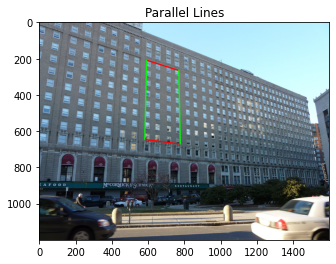

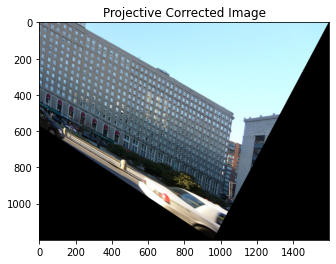

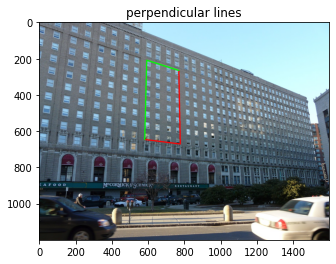

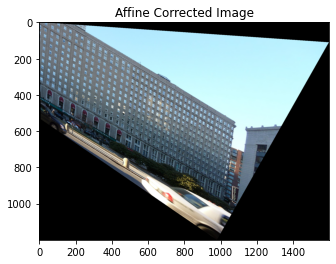

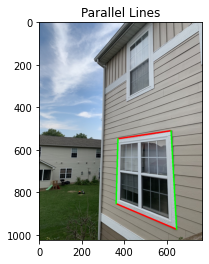

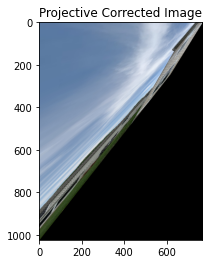

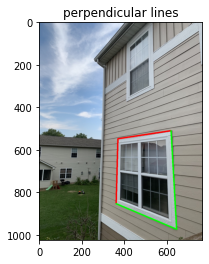

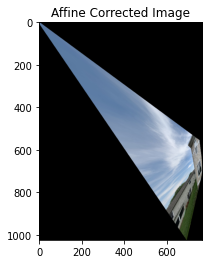

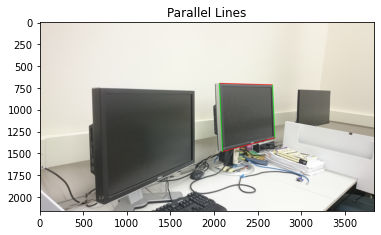

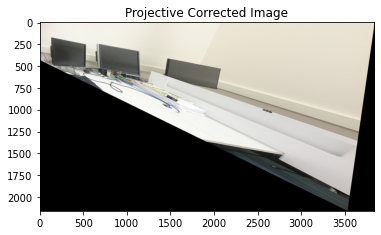

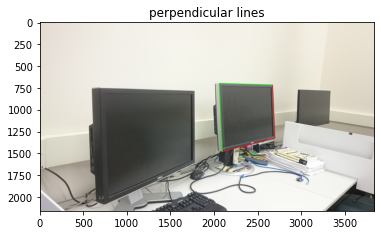

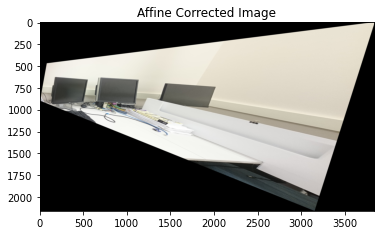

In [33]:
Rectification(1)
Rectification(2)
Rectification(3)